In [1]:
%load_ext autoreload
%autoreload 2

# Load the segmentation we want to track

In [2]:
import sys
sys.path.append('..')  # import bread
import bread.data
from glob import glob
import matplotlib.pyplot as plt

In [3]:
imgs_seg = bread.data.load_npz(sorted(glob('../data/segmentations/colony007/*.npz')))
# Note : we only load the phase contrast image for visualization purposes
imgs_vis = bread.data.load_npz(sorted(glob('../data/microscopy_PhC/colony007/*.npz')))

In [4]:
img_seg1, img_vis1 = imgs_seg[90], imgs_vis[90]
img_seg2, img_vis2 = imgs_seg[101], imgs_vis[101]

In [5]:
import bread.vis

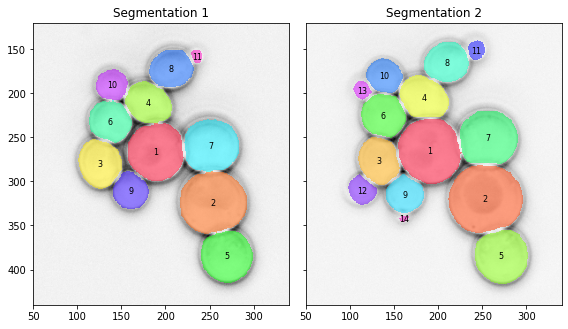

In [6]:
%matplotlib inline

plt.close('all')
fig, ax = plt.subplots(ncols=2, figsize=(2*4, 6), sharex=True, sharey=True, tight_layout=True)

ax[0].set_title('Segmentation 1')
bread.vis.plot_visible(img_vis1, figax=(fig, ax[0]))
bread.vis.plot_seg(img_seg1, figax=(fig, ax[0]), alpha=0.5)

ax[1].set_title('Segmentation 2')
bread.vis.plot_visible(img_vis2, figax=(fig, ax[1]))
bread.vis.plot_seg(img_seg2, figax=(fig, ax[1]), alpha=0.5)

ax[0].set_xlim((50, 340))
ax[0].set_ylim((440, 120))

plt.show(fig)

# Create the graph structure

In [7]:
import bread.data.graph

## Extract node and edge features

In [8]:
# Note : we return the dataframe with the features here for the purpose of visualization, this is optional
graph1, df_x1, df_e1 = bread.data.graph.build_cellgraph(img_seg1, max_membdist=12, return_df=True)
graph2, df_x2, df_e2 = bread.data.graph.build_cellgraph(img_seg2, max_membdist=12, return_df=True)

In [9]:
df_x1.head(5)

,cell_id,A,r_equiv,r_maj,r_min,alpha_maj,e
0,1,3357.0,32.744579,33.232666,32.263660,1.698028,0.239721
1,2,4293.5,37.004378,38.979233,35.129578,3.025859,0.433324
2,3,2142.5,26.231139,28.112005,24.476114,1.304370,0.491878
3,4,1932.5,24.885125,28.095465,22.041616,0.496721,0.620096
4,5,2781.5,29.794134,30.019131,29.570824,0.530639,0.172177


In [10]:
df_x2.head(5)

,cell_id,A,r_equiv,r_maj,r_min,alpha_maj,e
0,1,4173.0,36.489722,37.708080,35.310730,1.106018,0.350872
1,2,5192.5,40.696362,42.873783,38.629524,3.040075,0.433807
2,3,1941.0,24.956275,27.560139,22.598423,1.224955,0.572410
3,4,2104.0,25.992364,29.402651,22.977621,0.463198,0.623929
4,5,2972.0,30.824657,30.926222,30.723425,2.900314,0.114332


In [11]:
df_e1.head(5)

,cell_id1,cell_id2,rho,theta,l,diff_alpha
0,1,3,65.207241,1.775036,7.000000,2.747935
1,1,4,55.901624,0.155238,1.000000,1.940286
2,1,6,62.554882,0.984730,4.242641,2.046048
3,1,7,62.680110,-1.459482,2.000000,1.309548
4,1,9,53.017281,2.562644,2.000000,2.706374


In [12]:
df_e2.head(5)

,cell_id1,cell_id2,rho,theta,l,diff_alpha
0,1,2,83.203638,-2.283067,4.242641,1.207535
1,1,3,58.689613,1.758451,2.000000,0.118937
2,1,4,60.811081,0.111080,1.000000,0.642821
3,1,6,66.111154,0.920639,2.828427,0.558452
4,1,7,67.905849,-1.355857,1.000000,1.202742


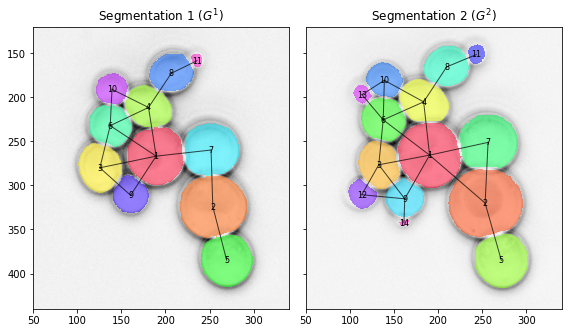

In [13]:
%matplotlib inline

plt.close('all')
fig, ax = plt.subplots(ncols=2, figsize=(4*2, 6), sharex=True, sharey=True, tight_layout=True)

ax[0].set_title('Segmentation 1 ($G^1$)')
bread.vis.plot_visible(img_vis1, figax=(fig, ax[0]))
bread.vis.plot_seg(img_seg1, figax=(fig, ax[0]), alpha=0.5)
bread.vis.plot_graph(img_seg1, df_e1.loc[:, ['cell_id1', 'cell_id2']].to_numpy(), figax=(fig, ax[0]))

ax[1].set_title('Segmentation 2 ($G^2$)')
bread.vis.plot_visible(img_vis2, figax=(fig, ax[1]))
bread.vis.plot_seg(img_seg2, figax=(fig, ax[1]), alpha=0.5)
bread.vis.plot_graph(img_seg2, df_e2.loc[:, ['cell_id1', 'cell_id2']].to_numpy(), figax=(fig, ax[1]))

ax[0].set_xlim((50, 340))
ax[0].set_ylim((440, 120))

plt.show(fig)

## Build the assignment graph

We visualize the assignment graph, and mark true assignments (correct tracks) in green, and false assignments (incorrect tracks) in red

In [14]:
import bread.vis.graph

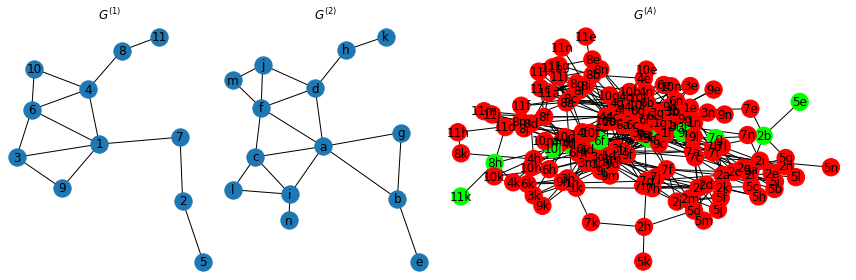

In [15]:
bread.vis.graph.plot_assignmentgraph_track(img_seg1, img_seg2, graph1, graph2);

We generate the assignment graph that we feed into the GNN. We also generate the ground truth assignment graph

Its node features consists of a concatenation of the two nodes (i.e. cells) it connects, and similarly for the edge features.

In [16]:
assgraph = bread.data.graph.build_assignmentgraph(graph1, graph2)
assgraph_truth = bread.data.graph.build_assignmentgraph_track(img_seg1, img_seg2)

In [17]:
import pandas as pd

In [18]:
pd.DataFrame(assgraph.x, dtype=float).head(5)

,0,1,2,3,4,5
0,3357.0,32.744579,0.239721,4173.0,36.489723,0.350872
1,3357.0,32.744579,0.239721,5192.5,40.696362,0.433807
2,3357.0,32.744579,0.239721,1941.0,24.956276,0.572410
3,3357.0,32.744579,0.239721,2104.0,25.992363,0.623929
4,3357.0,32.744579,0.239721,2972.0,30.824657,0.114332


In [19]:
pd.DataFrame(assgraph.edge_attr, dtype=float).head(5)

,0,1,2,3,4,5
0,65.207237,1.775036,7.0,83.203636,-2.283067,4.242640
1,65.207237,1.775036,7.0,58.689613,1.758451,2.000000
2,65.207237,1.775036,7.0,60.811081,0.111080,1.000000
3,65.207237,1.775036,7.0,66.111153,0.920639,2.828427
4,65.207237,1.775036,7.0,67.905846,-1.355857,1.000000


# Run the GNN

We load weights from a pretrained model.

In [20]:
from bread.algo.tracking.gnn import GNNNodeClassifier1
import torch

In [21]:
model = GNNNodeClassifier1.load_from_checkpoint('model_weights/GNN1_demo.ckpt')
model.eval()  # set to evaluation mode

GNNNodeClassifier1(
  (loss): CrossEntropyLoss()
  (node_encoder): MLP(6, 80, 80, 80)
  (edge_encoder): MLP(6, 80, 80, 80)
  (layers): ModuleList(
    (0): DeepGCNLayer(block=res+)
    (1): DeepGCNLayer(block=res+)
    (2): DeepGCNLayer(block=res+)
    (3): DeepGCNLayer(block=res+)
    (4): DeepGCNLayer(block=res+)
    (5): DeepGCNLayer(block=res+)
  )
  (lin): Linear(in_features=80, out_features=2, bias=True)
)

## Make a naive prediction

For each node in the resulting graph, assign the class that has the highest score.

In [22]:
y_hat = model.predict(assgraph)
y = assgraph_truth.x.T.squeeze().type(torch.long)
print(y)
print(y_hat)

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
 

In [23]:
print(f'total number of mistakes : {(y_hat != y).sum():1d}')

total number of mistakes : 2


## Investigate mistakes

2 tracking mistakes have been made. Where ? We can reshape the answer to build an one-hot assignment matrix, where each row corresponds to a cell of the first graph, and column to a cell of the second graph.

In [24]:
ass_matrix_naive = y_hat.reshape(graph1.num_nodes, graph2.num_nodes)
ass_matrix_naive

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

The 2nd and 5th row are indeed missing an assignment ! Why ? Let's look at the second row.

In [25]:
z = model(assgraph).detach().reshape(graph1.num_nodes, graph2.num_nodes, 2)
z[1]

tensor([[ 5.8031, -5.3657],
        [ 2.6981, -2.1873],
        [ 6.3044, -5.9648],
        [ 6.3212, -5.9531],
        [ 6.1206, -5.8909],
        [ 6.3131, -5.9699],
        [ 6.1870, -5.9010],
        [ 6.2561, -5.8895],
        [ 6.2425, -5.9322],
        [ 6.2820, -5.9746],
        [ 6.2195, -5.8408],
        [ 6.2586, -5.9058],
        [ 6.2632, -5.9535],
        [ 6.1410, -5.8113]])

These are the final weights for the cell 2 in the first graph. Each row corresponds to the weights (yes or no) for a connection with the corresponding cell in the second graph.

In this case, all the weights are larger in the "no" column, meaning the model thinks that the cell has been flushed away.

We can however see that for the second row, the model is the least sure of the classification, which we can use if we want to force to chose the best candidate in the second graph.

## Forwards tracking

We force the model to match each cell from the first graph to one from the second graph. (forwards forced tracking)

Note : this ignores that cells can be flushed away

In [26]:
z_diff = z.diff(axis=2)  # compute difference between "yes" and "no"
z_diff_max = z_diff.argmax(axis=1).type(torch.long)  # see where the model is the least sure about the yes/no distinction
ass_matrix_fw = torch.zeros(graph1.num_nodes, graph2.num_nodes, dtype=torch.long).scatter_(1, z_diff_max, 1)  # convert to one-hot vector
print(f'cell 1 in the first frame is attributed to cell {int(z_diff_max[1])} in the second frame')

cell 1 in the first frame is attributed to cell 1 in the second frame


Indeed, we see that now cell 2 from the first graph is matched to cell 2 from the second graph.

We can visualize the full assignment matrix :

In [27]:
ass_matrix_fw

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

This is implemented in `bread_nn` :

In [28]:
bread.algo.tracking.gnn.assmatrix_forward(z)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

## Backwards tracking

We can also force the model to match each cell from the second graph to one from the first graph. (backwards forced tracking). This prevents a cell from the second graph from being tracked back to multiple cells from the first graph.

Note : this ignores that cells can bud. since there are more cells in the second graph, each cell in the first graph may be tracked to more than one cell of the second graph.

In [29]:
z2_diff_max = z_diff.argmax(axis=0).type(torch.long)  # see where the model is the least sure about the yes/no distinction
ass_matrix_bw = torch.zeros(graph2.num_nodes, graph1.num_nodes, dtype=torch.long).scatter_(1, z2_diff_max, 1)  # convert to one-hot vector
ass_matrix_bw.T

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]])

This is implemented in `bread_nn` :

In [30]:
bread.algo.tracking.gnn.assmatrix_backward(z)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]])

A less naive method takes into account that if all entries in `z_diff` along one column are negative, then that column probably corresponds to a bud, and zeroes out the column.

In [31]:
bread.algo.tracking.gnn.assmatrix_backward_constrained(z)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

## Linear assignment optimizer

We can also realize that `z_diff` corresponds to scores for each assignment, and thus translates to a linear assignment problem. This can be solved using `scipy.optimize.linear_sum_assignment`, and the result is fully implemented.

When making predictions, this method performs the best, and should be used preferentially.

In [32]:
bread.algo.tracking.gnn.assmatrix_linear_sum(z)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

# Visualize the predicted tracking

We construct an array which maps cells from the second frame to cells from the first frame (if they exist)

In [33]:
def ass_to_track(ass_matrix):
	track = ass_matrix.argmax(axis=0)  # maps idx2 to idx1
	track_exists = ass_matrix.sum(axis=0).type(torch.bool)  # maps idx2 to whether a track exists
	track[~track_exists] = -1
	return track

In [34]:
track_naive = ass_to_track(ass_matrix_naive)
track_fw = ass_to_track(ass_matrix_fw)
track_bw = ass_to_track(ass_matrix_bw.T)
track_bwc = ass_to_track(bread.algo.tracking.gnn.assmatrix_backward_constrained(z))
track_linsum = ass_to_track(bread.algo.tracking.gnn.assmatrix_linear_sum(z))
print(track_naive, track_fw, track_bw, track_bwc, track_linsum, sep='\n')

tensor([ 0, -1,  2,  3,  4,  5, -1,  7,  8,  9, 10, -1, -1, -1])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, -1, -1, -1])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 10,  9,  2])
tensor([ 0, -1,  2,  3,  4,  5, -1,  7,  8,  9, 10, -1, -1, -1])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, -1, -1, -1])


In [35]:
import numpy as np
import bread.utils

cell_ids1 = bread.utils.get_cellids(img_seg1)
img_track_naive = img_seg2.copy()
img_track_fw = img_seg2.copy()
img_track_bw = img_seg2.copy()
img_track_bwc = img_seg2.copy()
img_track_linsum = img_seg2.copy()

for img_track_hat, track in zip((img_track_naive, img_track_fw, img_track_bw, img_track_bwc, img_track_linsum), (track_naive, track_fw, track_bw, track_bwc, track_linsum)):
	for idx2, cell_id2 in enumerate(bread.utils.get_cellids(img_seg2)):
		y, x = (img_seg2 == cell_id2).nonzero()  # indices of the cell we want to backtrack

		# predicted track
		idx1 = int(track[idx2])
		img_track_hat[y, x] = cell_ids1[idx1] if idx1 >= 0 else 0

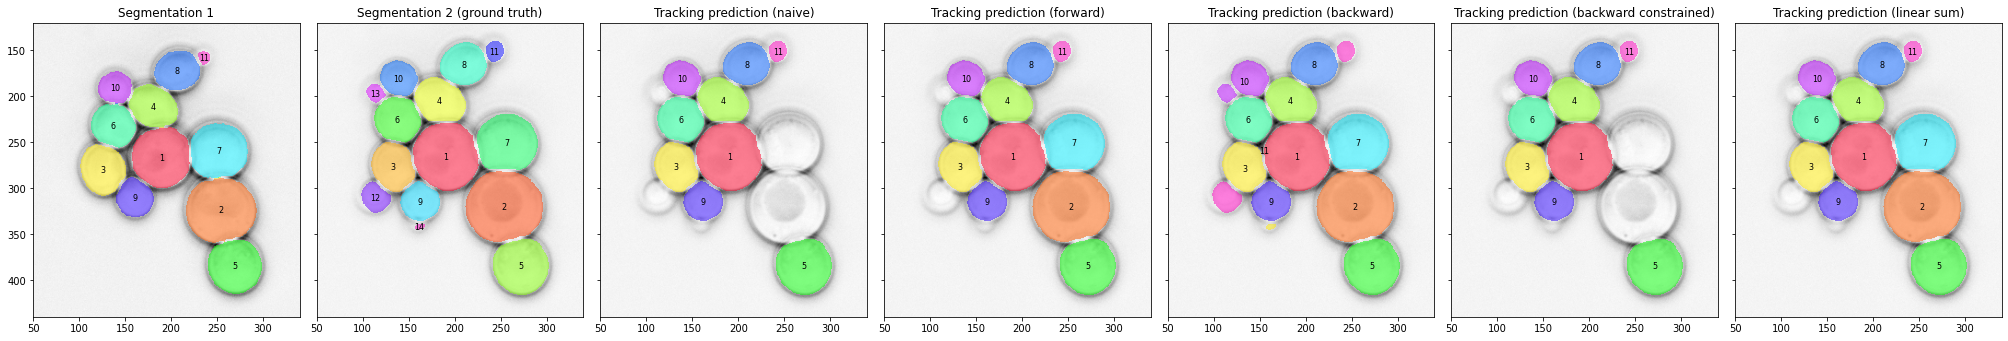

In [36]:
%matplotlib inline
plt.close('all')
fig, ax = plt.subplots(ncols=7, figsize=(4*7, 6), sharex=True, sharey=True, tight_layout=True)

ax[0].set_title('Segmentation 1')
bread.vis.plot_visible(img_vis1, figax=(fig, ax[0]))
bread.vis.plot_seg(img_seg1, figax=(fig, ax[0]), alpha=0.5)

ax[1].set_title('Segmentation 2 (ground truth)')
bread.vis.plot_visible(img_vis2, figax=(fig, ax[1]))
bread.vis.plot_seg(img_seg2, figax=(fig, ax[1]), alpha=0.5)

ax[2].set_title('Tracking prediction (naive)')
bread.vis.plot_visible(img_vis2, figax=(fig, ax[2]))
bread.vis.plot_seg(img_track_naive, figax=(fig, ax[2]), alpha=0.5)

ax[3].set_title('Tracking prediction (forward)')
bread.vis.plot_visible(img_vis2, figax=(fig, ax[3]))
bread.vis.plot_seg(img_track_fw, figax=(fig, ax[3]), alpha=0.5)

ax[4].set_title('Tracking prediction (backward)')
bread.vis.plot_visible(img_vis2, figax=(fig, ax[4]))
bread.vis.plot_seg(img_track_bw, figax=(fig, ax[4]), alpha=0.5)

ax[5].set_title('Tracking prediction (backward constrained)')
bread.vis.plot_visible(img_vis2, figax=(fig, ax[5]))
bread.vis.plot_seg(img_track_bwc, figax=(fig, ax[5]), alpha=0.5)

ax[6].set_title('Tracking prediction (linear sum)')
bread.vis.plot_visible(img_vis2, figax=(fig, ax[6]))
bread.vis.plot_seg(img_track_linsum, figax=(fig, ax[6]), alpha=0.5)

ax[0].set_xlim((50, 340))
ax[0].set_ylim((440, 120))

plt.show(fig)